In [1]:
from gurobipy import *
# Import everything needed
from itertools import *
import numpy as np
from numpy import genfromtxt
import matplotlib.pyplot as plt
import string
#import random
import pandas
import time
import datagenerator
import math
import networkx as nx
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")

In [5]:
gurobi_cl

NameError: name 'gurobi_cl' is not defined

In [3]:
n = 3
#distance, demand, cost
seeds = [5,30,25]
datagenerator.saveData(n,seeds[0],seeds[1],seeds[2])
locations = genfromtxt('LocationsCARP.csv', delimiter=',').astype(int)
demand = genfromtxt('DemandCARP.csv', delimiter=',').astype(int)
cost = genfromtxt('CostCARP.csv', delimiter=',').astype(int)
distance = genfromtxt('DistancesCARP.csv', delimiter=',').astype(int)
print(locations)
print(distance)
print(demand)
print(cost)

[[79 32]
 [94 45]
 [88 94]]
[[ 0 19 62]
 [19  0 49]
 [62 49  0]]
[[ 0 35 47]
 [35  0 80]
 [47 80  0]]
[[ 0 85 19]
 [85  0 66]
 [19 66  0]]


In [99]:
def getTrashType(n):
    x = 3
    P = 0.2
    b = np.random.choice([0,1], size=(x,x), p=[P, 1-P])
    bsymm = b.T * b
    return bsymm
T1 = getTrashType(n=3)
T2 = getTrashType(n=3)

In [101]:
t1q = T1*demand
t2q = T2*distance

In [102]:
t1q

array([[ 0, 35, 47],
       [35,  0,  0],
       [47,  0,  0]])

In [103]:
t2q

array([[ 0, 19,  0],
       [19,  0, 49],
       [ 0, 49,  0]])

### CARP Model Formulation

In [125]:
# Create a new model
m = Model("Capacitated Arc Routing Problem New Version")

# Create set
N = list(range(len(locations))) # Number of Nodes (5)
K = [0,1] #Vehicles or postmans (3)
FN = N[1:] #Set needed for Flow Variables

# Parameters
#Cij is the distance matrix
c = distance
Q = {0:t1q,1:t2q}
Pt={0:[1,0],1:[1,1]} # Trash type 0 can picked up by Vechicle 1, Trash type 1 can be picked up by Vehicle 1 and Vehicle 2
T = [0,1]

# Capacity of All the Vehicles
W = [125,250] #How do we determine capacity of vehicle?


# Create variables
xijp = m.addVars(N,N,K,vtype=GRB.BINARY,name="xijp") # = 1 if arc (i,j) of is traversed by vehicle k, 0 otherwise
lijp = m.addVars(N,N,K,vtype=GRB.BINARY,name="lijp") # = 1 if vehicle k services arc (i,j) 0 otherwise
fijp = m.addVars(N,N,K,vtype=GRB.CONTINUOUS,name="fijp") # is a flow variable which can take on positive values only if xjip = 1



# Set objective
#This objective function models the pairs of teams times the individual distance to the rival team
m.setObjective(sum(c[i][j]*xijp[i,j,p] for i in N for j in N for p in K), GRB.MINIMIZE)

# Add constraint: 
m.addConstrs((sum(xijp[j,i,p] for j in N)-sum(xijp[i,j,p] for j in N)==0 for i in N for p in K), "Route Continuity")
              
m.addConstrs((sum(lijp[i,j,p]*Pt[t][p] + lijp[j,i,p]*Pt[t][p] for p in K)>=math.ceil(Q[t][i][j]/W[p]) for i in N for j in N for p in K for t in T), 'Each Arc with Positive Demand is Served Exactly Once') 
               
m.addConstrs((xijp[i,j,p] >= lijp[i,j,p] for i in N for j in N for p in K), "guarantee that arc (i, j) can be serviced by vehicle p only if he covers arc (i,j) of type t")
               
m.addConstrs((sum(lijp[i,j,p]*Q[t][i][j] for i in N for j in N for t in T)<= W[p] for p in K), "Vehicle capacity")
               
m.addConstrs((sum(fijp[i,j,p] for j in N)-sum(fijp[j,i,p] for j in N)==sum(lijp[i,j,p] for j in N)for i in FN for p in K), "Constraint 6")
               
m.addConstrs((fijp[i,j,p] <= n**2*xijp[i,j,p] for i in N for j in N for p in K), "Constraint 6 Extended")
               
m.addConstrs((fijp[i,j,p] >= 0 for i in N for j in N for p in K), "Non-Negativity Constraint")

# Optimize model
m.optimize()


Optimize a model with 102 rows, 54 columns and 244 nonzeros
Variable types: 18 continuous, 36 integer (36 binary)
Coefficient statistics:
  Matrix range     [1e+00, 5e+01]
  Objective range  [2e+01, 6e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 3e+02]
Found heuristic solution: objective 396.0000000
Presolve removed 86 rows and 36 columns
Presolve time: 0.00s
Presolved: 16 rows, 18 columns, 50 nonzeros
Found heuristic solution: objective 266.0000000
Variable types: 6 continuous, 12 integer (12 binary)

Root relaxation: objective 1.857516e+02, 11 iterations, 0.00 seconds

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0  185.75163    0    7  266.00000  185.75163  30.2%     -    0s
     0     0  231.55556    0    5  266.00000  231.55556  12.9%     -    0s
H    0     0                     260.0000000  231.55556  10.9%     -    0s
     0     0     cutoff  

### Model Solution

In [126]:
vars = m.getVars()
gurobi_solution = {v.Varname : v.x for v in vars}
#gurobi_solution

In [127]:
filtered_dict = {k:v for k,v in gurobi_solution.items() if 'xijp' in k}
filtered_dict = {k:v for k,v in filtered_dict.items() if v == 1}
new = filtered_dict.keys()
new = [x.strip('xijp') for x in new]
new = [x.strip('][').split(', ') for x in new]
new = [x[0].split(",") for x in new]
dfXijp = pandas.DataFrame(new, columns = ['Node I', 'Node J', 'Vehicle P']).sort_values('Vehicle P',ascending=True) 
dfXijp = dfXijp[dfXijp['Node I'] != dfXijp['Node J']]
out1 = dfXijp.style.set_caption("XIJP Where Vehicle P Traverses Edge I,J")
out1

,Node I,Node J,Vehicle P
2,0,2,0
4,1,0,0
8,2,1,0
3,0,2,1
5,1,0,1
9,2,1,1


In [128]:
filtered_dict = {k:v for k,v in gurobi_solution.items() if 'lijp' in k}
filtered_dict = {k:v for k,v in filtered_dict.items() if v == 1}
new = filtered_dict.keys()
new = [x.strip('lijp') for x in new]
new = [x.strip('][').split(', ') for x in new]
new = [x[0].split(",") for x in new]
dfLijp = pandas.DataFrame(new, columns = ['Node I', 'Node J', 'Vehicle P']).sort_values('Vehicle P',ascending=True) 
out = dfLijp.style.set_caption("LIJP Where Vehicle P Services Edge I,J")
out

,Node I,Node J,Vehicle P
0,0,2,0
1,1,0,0
2,2,1,1


### Objective Value

In [129]:
print('Objective Value of VRP: %g' % m.objVal)

Objective Value of VRP: 260


In [130]:
def getEdges(TrashType):   
    TrashType = TrashType
    dfloc = pandas.DataFrame(locations,columns=['X','YCoor'])
    dfloc['Node'] = dfloc.index
    newDict={}
    for x in dfloc.index:
        newDict.update({dfloc['Node'][x]:np.array([dfloc['X'][x],dfloc['YCoor'][x]])})
    output = [[a, b] for a in N 
              for b in N] 
    edgeWeight = {}
    for n in range(len(output)):
        edgeWeight[tuple(output[n])]=Q[TrashType][output[n][0]][output[n][1]]
    filteredEdge = {k:v for k,v in edgeWeight.items() if v != 0}
    return [filteredEdge,edgeWeight,output,newDict]
def getGraph(path_edges,serviceDict,color,filteredEdge,output,newDict):
    edges = output
    G = nx.Graph()
    G.add_edges_from(edges)
    pos = newDict  
    path_edges = path_edges
    nx.draw_networkx_edges(G,pos,edgelist=path_edges,edge_color=color,width=3)
    nx.draw(G,pos,edge_color='black',width=1,linewidths=1,\
        node_size=500,node_color='orange',alpha=0.9,\
        labels={node:node for node in G.nodes()})
    nx.draw_networkx_edge_labels(G,pos,edge_labels=filteredEdge,font_color='black')
    nx.draw_networkx_edge_labels(G,pos,edge_labels=serviceDict,font_color='black',bbox=dict(color=color,alpha=0.2))
    return G
def getPathEdges(Vehicle):
    l1 = list(dfXijp[dfXijp['Vehicle P']==Vehicle]['Node I'].map(int))
    l2 = list(dfXijp[dfXijp['Vehicle P']==Vehicle]['Node J'].map(int))
    l3 = list(zip(l1,l2))
    return l3
def getServiceEdges(Vehicle):
    l1 = list(dfLijp[dfLijp['Vehicle P']==Vehicle]['Node I'].map(int))
    l2 = list(dfLijp[dfLijp['Vehicle P']==Vehicle]['Node J'].map(int))
    l3 = list(zip(l1,l2))
    return l3
def getRunningSum(TrashType):
    runningSum = 0
    formatted = np.triu(Q[TrashType],0)
    for x in formatted:
        for y in x:
            runningSum = runningSum + y
    return runningSum

# Trash Type 0 Vehicle 0 - Can be picked up V0

Serviced Edges by Vehicle: 0: [(0, 2), (1, 0)]
Path Edges by Vehicle 0: [(0, 2), (1, 0), (2, 1)]
Total Weight Met by Vehicle 0: 82 out of 82 for trash type: 0
Percentage of Weight met by Vehicle: 0: 100.0 for trash type: 0


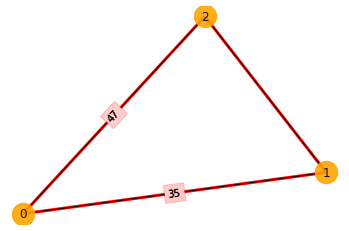

In [131]:
trashnum = 0
plotList = []
x=220
# for trashnum in trashList:
Vehicle = '0'
servicedList = getServiceEdges(Vehicle)
print("Serviced Edges by Vehicle: " + Vehicle +": " + str(servicedList))
path_edges = getPathEdges(Vehicle)
print("Path Edges by Vehicle " + Vehicle + ": " + str(path_edges))
vehicleSum0 = 0
tupEdges = getEdges(trashnum)
edgeWeight = tupEdges[1]
filteredEdge = tupEdges[0]
output = tupEdges[2]
newDict = tupEdges[3]
for key in edgeWeight:
    if key in servicedList:
        vehicleSum0 = vehicleSum0 + edgeWeight[key]
serviceDict = {}
color = {'0':'r','1':'b','2':'g'}
for (key, value) in filteredEdge.items():
    if key in servicedList:
        serviceDict[key] = value
getGraph(path_edges,serviceDict,color[Vehicle],filteredEdge,output,newDict)
print("Total Weight Met by Vehicle " + Vehicle + ": " + str(vehicleSum0) + " out of " + str(getRunningSum(trashnum)) + " for trash type: " + str(trashnum))
print("Percentage of Weight met by Vehicle: " + str(Vehicle) + ": " + str((vehicleSum0/getRunningSum(trashnum))*100) + " for trash type: " + str(trashnum))

# Trash Type 0 Vehicle 1 - Cannot Be Picked by V1

Serviced Edges by Vehicle: 1: [(2, 1)]
Path Edges by Vehicle 1: [(0, 2), (1, 0), (2, 1)]
Total Weight Met by Vehicle 1: 0 out of 82 for trash type: 0
Percentage of Weight met by Vehicle: 1: 0.0 for trash type: 0


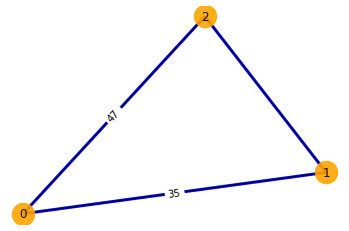

In [132]:
trashnum = 0
plotList = []
x=220
# for trashnum in trashList:
Vehicle = '1'
servicedList = getServiceEdges(Vehicle)
print("Serviced Edges by Vehicle: " + Vehicle +": " + str(servicedList))
path_edges = getPathEdges(Vehicle)
print("Path Edges by Vehicle " + Vehicle + ": " + str(path_edges))
vehicleSum0 = 0
tupEdges = getEdges(trashnum)
edgeWeight = tupEdges[1]
filteredEdge = tupEdges[0]
output = tupEdges[2]
newDict = tupEdges[3]
for key in edgeWeight:
    if key in servicedList:
        vehicleSum0 = vehicleSum0 + edgeWeight[key]
serviceDict = {}
color = {'0':'r','1':'b','2':'g'}
for (key, value) in filteredEdge.items():
    if key in servicedList:
        serviceDict[key] = value
getGraph(path_edges,serviceDict,color[Vehicle],filteredEdge,output,newDict)
print("Total Weight Met by Vehicle " + Vehicle + ": " + str(vehicleSum0) + " out of " + str(getRunningSum(trashnum)) + " for trash type: " + str(trashnum))
print("Percentage of Weight met by Vehicle: " + str(Vehicle) + ": " + str((vehicleSum0/getRunningSum(trashnum))*100) + " for trash type: " + str(trashnum))

# Trash Type 1 Vehicle 0 - Can be Picked up by V0

Serviced Edges by Vehicle: 0: [(0, 2), (1, 0)]
Path Edges by Vehicle 0: [(0, 2), (1, 0), (2, 1)]
Total Weight Met by Vehicle 0: 19 out of 68 for trash type: 1
Percentage of Weight met by Vehicle: 0: 27.941176470588236 for trash type: 1


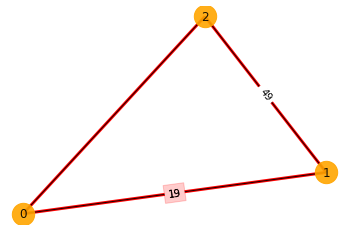

In [133]:
trashnum = 1
plotList = []
x=220
# for trashnum in trashList:
Vehicle = '0'
servicedList = getServiceEdges(Vehicle)
print("Serviced Edges by Vehicle: " + Vehicle +": " + str(servicedList))
path_edges = getPathEdges(Vehicle)
print("Path Edges by Vehicle " + Vehicle + ": " + str(path_edges))
vehicleSum0 = 0
tupEdges = getEdges(trashnum)
edgeWeight = tupEdges[1]
filteredEdge = tupEdges[0]
output = tupEdges[2]
newDict = tupEdges[3]
for key in edgeWeight:
    if key in servicedList:
        vehicleSum0 = vehicleSum0 + edgeWeight[key]
serviceDict = {}
color = {'0':'r','1':'b','2':'g'}
for (key, value) in filteredEdge.items():
    if key in servicedList:
        serviceDict[key] = value
getGraph(path_edges,serviceDict,color[Vehicle],filteredEdge,output,newDict)
print("Total Weight Met by Vehicle " + Vehicle + ": " + str(vehicleSum0) + " out of " + str(getRunningSum(trashnum)) + " for trash type: " + str(trashnum))
print("Percentage of Weight met by Vehicle: " + str(Vehicle) + ": " + str((vehicleSum0/getRunningSum(trashnum))*100) + " for trash type: " + str(trashnum))

# Trash Type 1 Vehicle 1 - Can be picked by Vehicle 1

Serviced Edges by Vehicle: 1: [(2, 1)]
Path Edges by Vehicle 1: [(0, 2), (1, 0), (2, 1)]
Total Weight Met by Vehicle 1: 49 out of 68 for trash type: 1
Percentage of Weight met by Vehicle: 1: 72.05882352941177 for trash type: 1


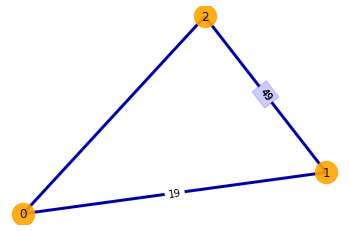

In [134]:
trashnum = 1
plotList = []
x=220
# for trashnum in trashList:
Vehicle = '1'
servicedList = getServiceEdges(Vehicle)
print("Serviced Edges by Vehicle: " + Vehicle +": " + str(servicedList))
path_edges = getPathEdges(Vehicle)
print("Path Edges by Vehicle " + Vehicle + ": " + str(path_edges))
vehicleSum0 = 0
tupEdges = getEdges(trashnum)
edgeWeight = tupEdges[1]
filteredEdge = tupEdges[0]
output = tupEdges[2]
newDict = tupEdges[3]
for key in edgeWeight:
    if key in servicedList:
        vehicleSum0 = vehicleSum0 + edgeWeight[key]
serviceDict = {}
color = {'0':'r','1':'b','2':'g'}
for (key, value) in filteredEdge.items():
    if key in servicedList:
        serviceDict[key] = value
getGraph(path_edges,serviceDict,color[Vehicle],filteredEdge,output,newDict)
print("Total Weight Met by Vehicle " + Vehicle + ": " + str(vehicleSum0) + " out of " + str(getRunningSum(trashnum)) + " for trash type: " + str(trashnum))
print("Percentage of Weight met by Vehicle: " + str(Vehicle) + ": " + str((vehicleSum0/getRunningSum(trashnum))*100) + " for trash type: " + str(trashnum))

In [86]:
 m.write("Solution.lp")